In [1]:
from IPython.core.display import display, HTML
#makes the display bars longer and spread out 100% across the screen width
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

import collections

import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path

import db_queries as db
import vivarium_helpers.id_helper as idh

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import nathaniel.model_validation.ciff_output_processing as cop

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model2
ndbs
Thu Aug  5 18:26:17 PDT 2021


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!ls /ihme/homes/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/

v2.1_gbd_2020_wasting  v2.3_wasting_birth_prevalence  v2.4_corrected_fertility


In [5]:
!ls /ihme/costeffectiveness/results/vivarium_ciff_sam/

v0.0_demography				     v2.0_wasting
v1.0_causes				     v2.1_gbd_2020_wasting_data
v1.1_causes_multiple_draws		     v2.2_pem
v1.2_adjusted_lri_prevalence		     v2.3_wasting_birth_prevalence
v1.3_ajusted_lri_prevalence_no_wasting	     v2.4_corrected_fertility
v1.4_adjusted_early_neonatal_lri_prevalence  v2.5_stunting


# Define directories, and create output directories if they don't exist

I'll use [pathlib.Path.mkdir](https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir) to (potentially) create the directories. See https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-nested-directory-in-python

In [6]:
# sim results path:
# /ihme/costeffectiveness/results/vivarium_ciff_sam/v2.4_corrected_fertility/ciff_sam/2021_08_03_15_08_32/count_data

project_results_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam'
model_name = 'v2.4_corrected_fertility'
model_timestamp = '2021_08_03_15_08_32'
username = 'ndbs'

In [7]:
model_count_data_dir = f'{project_results_dir}/{model_name}/ciff_sam/{model_timestamp}/count_data/'

project_vv_directory_name = 'ciff_malnutrition/verification_and_validation'

output_dir = f'/ihme/homes/{username}/vivarium_results/{project_vv_directory_name}/{model_name}'
share_output_dir = f'/share/scratch/users/ndbs/vivarium_results/{project_vv_directory_name}/{model_name}'
j_output_dir = f'/home/j/Project/simulation_science/{project_vv_directory_name}/{model_name}'

# Create the output directories if they don't exist
# Note from Path.mkdir() documentation:
#   "If mode is given, it is combined with the process’ umask value to determine the file mode and access flags."
#
# I don't know what this notebook process' umask value will be, so I don't know if this will actually result
# in the correct (most permissive) permissions for the directories...
for directory in [output_dir, share_output_dir, j_output_dir]:
    Path(directory).mkdir(mode=0o777, parents=True, exist_ok=True)

# Load transformed count data

In [8]:
data = vto.VivariumTransformedOutput.from_directory(model_count_data_dir)
data.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'population',
 'ylls',
 'ylds',
 'disease_state_person_time',
 'disease_transition_count']

# Write a function to marginalize out (i.e. sum over) one or more columns in a dataframe

In [9]:
def marginalize(df:pd.DataFrame, marginalized_cols, value_cols='value', reset_index=True)->pd.DataFrame:
    """Sum the values of a dataframe over the specified columns to marginalize out.
    
    https://en.wikipedia.org/wiki/Marginal_distribution
    
    Parameters
    ----------
    
    df: DataFrame
        A dataframe with at least one "value" column to be aggregated, and additional "identifier" columns,
        at least one of which is to be marginalized out. That is, the data in the "value" column(s) will be summed
        over all catgories in the "marginalized" column(s). All columns in the dataframe are assumed to be either
        "value" columns or "identifier" columns, and the columns to marginalize should be a subset of the
        identifier columns.
    
    martinalized_cols: single column label, list of column labels, or pd.Index object
        The column(s) to sum over (i.e. marginalize)
        
    value_cols: single column label, list of column labels, or pd.Index object
        The column(s) in the dataframe that contain the values to sum
        
    reset_index: bool
        Whether to reset the dataframe's index after calling groupby().sum()
        
    Returns
    ------------
    summed_data: DataFrame
        DataFrame with the summed values, whose columns are the same as those in df except without `marginalized_cols`,
        which have been aggregated over.
        If reset_index == False, all the resulting columns will be placed in the DataFrame's index except for `value_cols`.
    """
    marginalized_cols = marginalized_cols if isinstance(marginalized_cols, (list, pd.Index)) else [marginalized_cols]
    value_cols = value_cols if isinstance(value_cols, (list, pd.Index)) else [value_cols]
    # Move MultiIndex levels into columns to enable passing index level names as well as column names
#     df = df.reset_index([level_name for level_name in df.index.names if level_name is not None])
    df = df.reset_index() if df.index.nlevels > 1 else df
    index_cols = df.columns.difference([*marginalized_cols, *value_cols]).to_list()
    summed_data = df.groupby(index_cols, observed=True)[value_cols].sum() # observed=True needed for Categorical data
    return summed_data.reset_index() if reset_index else summed_data

# Rename mislabeled 'cause' column in wasting_state_person_time table

In [10]:
d = data
d.wasting_state_person_time

,sex,year,cause,measure,input_draw,scenario,value,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,405.629021,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,1209.319644,late_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,8750.485969,1-5_months
3,female,2022,mild_child_wasting,state_person_time,29,baseline,10229.859001,6-11_months
...,...,...,...,...,...,...,...,...
2876,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,29966.584531,1-5_months
2877,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,35341.488022,6-11_months
2878,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,70143.459274,12_to_23_months
2879,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,213284.266940,2_to_4


In [11]:
d.wasting_state_person_time.rename(columns={'cause':'wasting_state'}, inplace=True)
d.wasting_state_person_time

,sex,year,wasting_state,measure,input_draw,scenario,value,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,405.629021,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,1209.319644,late_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,8750.485969,1-5_months
3,female,2022,mild_child_wasting,state_person_time,29,baseline,10229.859001,6-11_months
...,...,...,...,...,...,...,...,...
2876,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,29966.584531,1-5_months
2877,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,35341.488022,6-11_months
2878,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,70143.459274,12_to_23_months
2879,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,213284.266940,2_to_4


In [12]:
d['wasting_state_person_time'] # Test access via __getitem__

,sex,year,wasting_state,measure,input_draw,scenario,value,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,405.629021,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,1209.319644,late_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,8750.485969,1-5_months
3,female,2022,mild_child_wasting,state_person_time,29,baseline,10229.859001,6-11_months
...,...,...,...,...,...,...,...,...
2876,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,29966.584531,1-5_months
2877,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,35341.488022,6-11_months
2878,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,70143.459274,12_to_23_months
2879,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,213284.266940,2_to_4


In [13]:
d.wasting_state_person_time.wasting_state.unique()

array(['mild_child_wasting', 'moderate_acute_malnutrition',
       'severe_acute_malnutrition', 'susceptible_to_child_wasting'],
      dtype=object)

# Investigate disease_state_person_time table

In [14]:
d.disease_state_person_time

,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,female,2022,diarrheal_diseases,state_person_time,29,baseline,29.623546,susceptible_to_child_wasting,early_neonatal
1,female,2022,diarrheal_diseases,state_person_time,29,baseline,8.902122,mild_child_wasting,early_neonatal
2,female,2022,diarrheal_diseases,state_person_time,29,baseline,3.405886,moderate_acute_malnutrition,early_neonatal
3,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.863792,severe_acute_malnutrition,early_neonatal
...,...,...,...,...,...,...,...,...,...
17276,male,2026,susceptible_to_measles,state_person_time,946,baseline,213260.002738,susceptible_to_child_wasting,2_to_4
17277,male,2026,susceptible_to_measles,state_person_time,946,baseline,71097.534565,mild_child_wasting,2_to_4
17278,male,2026,susceptible_to_measles,state_person_time,946,baseline,25092.767967,moderate_acute_malnutrition,2_to_4
17279,male,2026,susceptible_to_measles,state_person_time,946,baseline,5442.572211,severe_acute_malnutrition,2_to_4


In [15]:
dd_person_time = d.disease_state_person_time.query('cause in ["diarrheal_diseases", "susceptible_to_diarrheal_diseases"]')
dd_person_time

,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,female,2022,diarrheal_diseases,state_person_time,29,baseline,29.623546,susceptible_to_child_wasting,early_neonatal
1,female,2022,diarrheal_diseases,state_person_time,29,baseline,8.902122,mild_child_wasting,early_neonatal
2,female,2022,diarrheal_diseases,state_person_time,29,baseline,3.405886,moderate_acute_malnutrition,early_neonatal
3,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.863792,severe_acute_malnutrition,early_neonatal
...,...,...,...,...,...,...,...,...,...
16700,male,2026,susceptible_to_diarrheal_diseases,state_person_time,946,baseline,209909.121150,susceptible_to_child_wasting,2_to_4
16701,male,2026,susceptible_to_diarrheal_diseases,state_person_time,946,baseline,69506.173854,mild_child_wasting,2_to_4
16702,male,2026,susceptible_to_diarrheal_diseases,state_person_time,946,baseline,24021.308693,moderate_acute_malnutrition,2_to_4
16703,male,2026,susceptible_to_diarrheal_diseases,state_person_time,946,baseline,4770.407940,severe_acute_malnutrition,2_to_4


In [16]:
# Twice as many rows in this as in wasting state PT df
5760/2880

2.0

# Compare disease state PT from diarrhea with wasting state PT

**The two dataframes are equal!** Unlike in Model v2.3.

In [17]:
# Sum DD person time df over the two cause states to get total person time in each wasting state
dd_pt_by_wasting_state = marginalize(dd_person_time, 'cause', reset_index=False)
dd_pt_by_wasting_state

value
age           input_draw measure           scenario sex    wasting_state                year             
1-5_months    29         state_person_time baseline female mild_child_wasting           2022  8750.485969
                                                                                        2023  8799.630390
                                                                                        2024  8743.301848
                                                                                        2025  8730.903491
...                                                                                                   ...
late_neonatal 946        state_person_time baseline male   susceptible_to_child_wasting 2023  4116.992471
                                                                                        2024  4136.361396
                                                                                        2025  4136.888433
                                                                                        2026  4101.040383

[2880 rows x 1 columns]

In [18]:
dd_pt_by_wasting_state.index.names

FrozenList(['age', 'input_draw', 'measure', 'scenario', 'sex', 'wasting_state', 'year'])

In [19]:
# The rows are in a different order than in the DD person-time data above
wspt = d.wasting_state_person_time.set_index(dd_pt_by_wasting_state.index.names)
wspt

,,,,,,,value
age,input_draw,measure,scenario,sex,wasting_state,year,
early_neonatal,29,state_person_time,baseline,female,mild_child_wasting,2022,405.629021
late_neonatal,29,state_person_time,baseline,female,mild_child_wasting,2022,1209.319644
1-5_months,29,state_person_time,baseline,female,mild_child_wasting,2022,8750.485969
6-11_months,29,state_person_time,baseline,female,mild_child_wasting,2022,10229.859001
...,...,...,...,...,...,...,...
1-5_months,946,state_person_time,baseline,male,susceptible_to_child_wasting,2026,29966.584531
6-11_months,946,state_person_time,baseline,male,susceptible_to_child_wasting,2026,35341.488022
12_to_23_months,946,state_person_time,baseline,male,susceptible_to_child_wasting,2026,70143.459274
2_to_4,946,state_person_time,baseline,male,susceptible_to_child_wasting,2026,213284.266940


In [20]:
# Use .reindex() to align the indices so we can compare the values
wspt = wspt.reindex(dd_pt_by_wasting_state.index)
wspt

value
age           input_draw measure           scenario sex    wasting_state                year             
1-5_months    29         state_person_time baseline female mild_child_wasting           2022  8750.485969
                                                                                        2023  8799.630390
                                                                                        2024  8743.301848
                                                                                        2025  8730.903491
...                                                                                                   ...
late_neonatal 946        state_person_time baseline male   susceptible_to_child_wasting 2023  4116.992471
                                                                                        2024  4136.361396
                                                                                        2025  4136.888433
                                                                                        2026  4101.040383

[2880 rows x 1 columns]

In [21]:
# Ok good, now one person-time count is NOT always greater than the other
(wspt > dd_pt_by_wasting_state).all()

value    False
dtype: bool

In [22]:
## Looks like wasting state PT is always 1.0 than the corresponding PT from diarrhea. Woo hoo!
(wspt / dd_pt_by_wasting_state).describe()

,value
count,2.880000e+03
mean,1.000000e+00
std,7.075271e-16
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [23]:
# Ok, not exactly equal due to rounding error, but the above .describe() shows that they're very close to equal
wspt.equals(dd_pt_by_wasting_state)

False

## Use `DataFrame.compare()` to see the values from the two dataframes side-by-side

By default, `.compare()` only shows values that are different, so it looks like there are 2529 out of 2880 rows where the values are NOT exactly equal, but they still agree up to all the displayed digits.

In [24]:
# Look, there's a new .compare() method introduced in pandas 1.1!

# Unfortunatly, like .equals(), .compare() only works for identically indexed obects,
# so the above call to .reindex() is still necessary to get this to work
wspt.compare(dd_pt_by_wasting_state)

value  \
                                                                                                     self   
age           input_draw measure           scenario sex    wasting_state                year                
1-5_months    29         state_person_time baseline female mild_child_wasting           2024  8743.301848   
                                                                                        2025  8730.903491   
                                                           moderate_acute_malnutrition  2022  3465.013005   
                                                                                        2023  3417.963039   
...                                                                                                   ...   
late_neonatal 946        state_person_time baseline male   susceptible_to_child_wasting 2023  4116.992471   
                                                                                        2024  4136.361396   
                                                                                        2025  4136.888433   
                                                                                        2026  4101.040383   

                                                                                                           
                                                                                                    other  
age           input_draw measure           scenario sex    wasting_state                year               
1-5_months    29         state_person_time baseline female mild_child_wasting           2024  8743.301848  
                                                                                        2025  8730.903491  
                                                           moderate_acute_malnutrition  2022  3465.013005  
                                                                                        2023  3417.963039  
...                                                                                                   ...  
late_neonatal 946        state_person_time baseline male   susceptible_to_child_wasting 2023  4116.992471  
                                                                                        2024  4136.361396  
                                                                                        2025  4136.888433  
                                                                                        2026  4101.040383  

[2529 rows x 2 columns]

# Try grouping disease_state_person_time by cause, and then summing

Looks like the total person time is the same for all three causes.

In [25]:
d.disease_state_person_time.cause.unique()

array(['diarrheal_diseases', 'lower_respiratory_infections', 'measles',
       'susceptible_to_diarrheal_diseases',
       'susceptible_to_lower_respiratory_infections',
       'susceptible_to_measles'], dtype=object)

In [26]:
causes = [c for c in d.disease_state_person_time.cause.unique() if not c.startswith('susceptible')]
causes

['diarrheal_diseases', 'lower_respiratory_infections', 'measles']

In [27]:
[s.replace('susceptible_to_', '') for s in d.disease_state_person_time.cause.unique()]

['diarrheal_diseases',
 'lower_respiratory_infections',
 'measles',
 'diarrheal_diseases',
 'lower_respiratory_infections',
 'measles']

## Rename poorly named 'cause' column and add an actual cause column

In [28]:
dspt = (
    d.disease_state_person_time
    .rename(columns={'cause':'cause_state'})
    .assign(cause=lambda df: df['cause_state'].str.replace('susceptible_to_', ''))
)
dspt

,sex,year,cause_state,measure,input_draw,scenario,value,wasting_state,age,cause
0,female,2022,diarrheal_diseases,state_person_time,29,baseline,29.623546,susceptible_to_child_wasting,early_neonatal,diarrheal_diseases
1,female,2022,diarrheal_diseases,state_person_time,29,baseline,8.902122,mild_child_wasting,early_neonatal,diarrheal_diseases
2,female,2022,diarrheal_diseases,state_person_time,29,baseline,3.405886,moderate_acute_malnutrition,early_neonatal,diarrheal_diseases
3,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.863792,severe_acute_malnutrition,early_neonatal,diarrheal_diseases
...,...,...,...,...,...,...,...,...,...,...
17276,male,2026,susceptible_to_measles,state_person_time,946,baseline,213260.002738,susceptible_to_child_wasting,2_to_4,measles
17277,male,2026,susceptible_to_measles,state_person_time,946,baseline,71097.534565,mild_child_wasting,2_to_4,measles
17278,male,2026,susceptible_to_measles,state_person_time,946,baseline,25092.767967,moderate_acute_malnutrition,2_to_4,measles
17279,male,2026,susceptible_to_measles,state_person_time,946,baseline,5442.572211,severe_acute_malnutrition,2_to_4,measles


In [29]:
# Sum over cause states for each cause to get person time in each wasting state
disease_pt_by_wasting_state_and_cause = marginalize(dspt, 'cause_state')
disease_pt_by_wasting_state_and_cause

,age,cause,input_draw,measure,scenario,sex,wasting_state,year,value
0,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,2022,8750.485969
1,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,2023,8799.630390
2,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,2024,8743.301848
3,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,2025,8730.903491
...,...,...,...,...,...,...,...,...,...
8636,late_neonatal,measles,946,state_person_time,baseline,male,susceptible_to_child_wasting,2023,4116.992471
8637,late_neonatal,measles,946,state_person_time,baseline,male,susceptible_to_child_wasting,2024,4136.361396
8638,late_neonatal,measles,946,state_person_time,baseline,male,susceptible_to_child_wasting,2025,4136.888433
8639,late_neonatal,measles,946,state_person_time,baseline,male,susceptible_to_child_wasting,2026,4101.040383


In [30]:
# Looks like total person time is the same for all 3 diseases
disease_pt_by_wasting_state_and_cause.groupby('cause').sum()

,input_draw,value
cause,,
diarrheal_diseases,1462800,6.113644e+07
lower_respiratory_infections,1462800,6.113644e+07
measles,1462800,6.113644e+07


# Calculate total person time

In [31]:
dd_pt_by_wasting_state

value
age           input_draw measure           scenario sex    wasting_state                year             
1-5_months    29         state_person_time baseline female mild_child_wasting           2022  8750.485969
                                                                                        2023  8799.630390
                                                                                        2024  8743.301848
                                                                                        2025  8730.903491
...                                                                                                   ...
late_neonatal 946        state_person_time baseline male   susceptible_to_child_wasting 2023  4116.992471
                                                                                        2024  4136.361396
                                                                                        2025  4136.888433
                                                                                        2026  4101.040383

[2880 rows x 1 columns]

In [32]:
person_time = marginalize(dd_pt_by_wasting_state, ['wasting_state'])
person_time

,age,input_draw,measure,scenario,sex,year,value
0,1-5_months,29,state_person_time,baseline,female,2022,43265.013005
1,1-5_months,29,state_person_time,baseline,female,2023,42973.642710
2,1-5_months,29,state_person_time,baseline,female,2024,43036.006845
3,1-5_months,29,state_person_time,baseline,female,2025,42856.635181
...,...,...,...,...,...,...,...
716,late_neonatal,946,state_person_time,baseline,male,2023,6200.603696
717,late_neonatal,946,state_person_time,baseline,male,2024,6221.069131
718,late_neonatal,946,state_person_time,baseline,male,2025,6228.291581
719,late_neonatal,946,state_person_time,baseline,male,2026,6180.350445


In [33]:
person_time.dtypes

age            object
input_draw      int64
measure        object
scenario       object
sex            object
year           object
value         float64
dtype: object

### Append total person-time summed over age groups

In [34]:
# Append total person time summed over age groups
person_time = (
    marginalize(person_time, 'age')
    .assign(age='all')
    [person_time.columns]
    .append(person_time, ignore_index=True)
)
person_time

,age,input_draw,measure,scenario,sex,year,value
0,all,29,state_person_time,baseline,female,2022,482158.668036
1,all,29,state_person_time,baseline,female,2023,489735.956194
2,all,29,state_person_time,baseline,female,2024,496836.391513
3,all,29,state_person_time,baseline,female,2025,499230.873374
...,...,...,...,...,...,...,...
836,late_neonatal,946,state_person_time,baseline,male,2023,6200.603696
837,late_neonatal,946,state_person_time,baseline,male,2024,6221.069131
838,late_neonatal,946,state_person_time,baseline,male,2025,6228.291581
839,late_neonatal,946,state_person_time,baseline,male,2026,6180.350445


In [35]:
cop.describe(person_time)

count          mean  \
age           measure           scenario sex    year                        
1-5_months    state_person_time baseline female 2022   12.0  43392.835843   
                                                2023   12.0  43391.629820   
                                                2024   12.0  43551.454255   
                                                2025   12.0  43375.110084   
...                                                     ...           ...   
late_neonatal state_person_time baseline male   2023   12.0   6197.427447   
                                                2024   12.0   6231.045517   
                                                2025   12.0   6210.325804   
                                                2026   12.0   6194.960643   

                                                             std  \
age           measure           scenario sex    year               
1-5_months    state_person_time baseline female 2022  547.723012   
                                                2023  556.848679   
                                                2024  531.722924   
                                                2025  533.704802   
...                                                          ...   
late_neonatal state_person_time baseline male   2023   79.847369   
                                                2024   80.858903   
                                                2025   96.948471   
                                                2026   75.113000   

                                                               min  \
age           measure           scenario sex    year                 
1-5_months    state_person_time baseline female 2022  42316.616016   
                                                2023  42338.826831   
                                                2024  42659.650924   
                                                2025  42732.076660   
...                                                            ...   
late_neonatal state_person_time baseline male   2023   6050.642026   
                                                2024   6079.452430   
                                                2025   6006.702259   
                                                2026   6073.437372   

                                                               25%  \
age           measure           scenario sex    year                 
1-5_months    state_person_time baseline female 2022  43053.239562   
                                                2023  42964.691992   
                                                2024  43177.678303   
                                                2025  42853.929843   
...                                                            ...   
late_neonatal state_person_time baseline male   2023   6143.599247   
                                                2024   6182.596167   
                                                2025   6157.985969   
                                                2026   6133.446270   

                                                               50%  \
age           measure           scenario sex    year                 
1-5_months    state_person_time baseline female 2022  43368.778234   
                                                2023  43432.768652   
                                                2024  43629.199179   
                                                2025  43369.039699   
...                                                            ...   
late_neonatal state_person_time baseline male   2023   6200.850787   
                                                2024   6231.142368   
                                                2025   6217.072553   
                                                2026   6189.169062   

                                                               75%  \
age           measure           scenario sex    year                 
1-5_

In [36]:
person_time_summary = cop.get_mean_lower_upper(cop.describe(person_time, percentiles=[.025,.975]))
person_time_summary

,age,measure,scenario,sex,year,mean,lower,upper
0,1-5_months,state_person_time,baseline,female,2022,43392.835843,42451.287714,44009.715777
1,1-5_months,state_person_time,baseline,female,2023,43391.629820,42465.237611,44208.982923
2,1-5_months,state_person_time,baseline,female,2024,43551.454255,42742.924538,44380.527139
3,1-5_months,state_person_time,baseline,female,2025,43375.110084,42757.755373,44159.286790
...,...,...,...,...,...,...,...,...
66,late_neonatal,state_person_time,baseline,male,2023,6197.427447,6068.135866,6323.009959
67,late_neonatal,state_person_time,baseline,male,2024,6231.045517,6097.066359,6342.577481
68,late_neonatal,state_person_time,baseline,male,2025,6210.325804,6038.846201,6337.396920
69,late_neonatal,state_person_time,baseline,male,2026,6194.960643,6087.504723,6300.969473


# Get a list of sorted age groups for plotting

In [37]:
person_time_summary.age.unique()

array(['1-5_months', '12_to_23_months', '2_to_4', '6-11_months', 'all',
       'early_neonatal', 'late_neonatal'], dtype=object)

In [38]:
# Get a list of sorted age groups to use for plotting
sorted_ages = ['early_neonatal', 'late_neonatal', '1-5_months', '6-11_months', '12_to_23_months', '2_to_4', 'all']
len(sorted_ages)

7

In [39]:
# # We could use an ordered Categorical if we want to automatically sort age groups in the dataframes:

# from pandas.api.types import CategoricalDtype
# age_dtype = CategoricalDtype(categories=sorted_ages, ordered=True)
# # df['age'] = df['age'].astype(age_dtype)

# Some sample plotting code from Beatrix's notebook

In [40]:
# Beatrix's plotting code for wasting state person-time vs. year:
def plot_wasting_pt_over_time(df, sex, age_group):
    
    df.year = df.year.astype(int)
    state = df.cause.iloc[0]
    
    #{1: 'early_neonatal', 2: 'late_neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age_map = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age = age_map[age_group]
    
    plt.figure(figsize=(6, 4), dpi=120)
    for cause in df.cause.unique():
        sub = df.loc[(df.sex==sex) & (df.age_group==age_group) & (df.cause==cause)]
        plt.plot(sub['year'], sub['mean'], marker='o', label=cause)
        plt.fill_between(sub['year'], sub['2.5%'], sub['97.5%'], alpha=.3)

    plt.legend(loc=(1.05, .1))
    plt.xlabel('Year')
    plt.ylabel('Person-years')
    plt.xticks(ticks = range(df.year.min(), df.year.max()+1))#, labels = ['early neonatal', 'late neonatal', 'post neonatal', '1 to 4'], rotation = 45) 
    plt.title(f'{age} person-time spent in wasting states ({sex})')

# for age_group in pt_tmrel_wasting.age_group.unique():
#     plot_wasting_pt_over_time(wasting_pt_df, sex = 'female', age_group = age_group)


# Plot person-time vs. year

### First define a function to plot measure vs. year on a specified Axes object

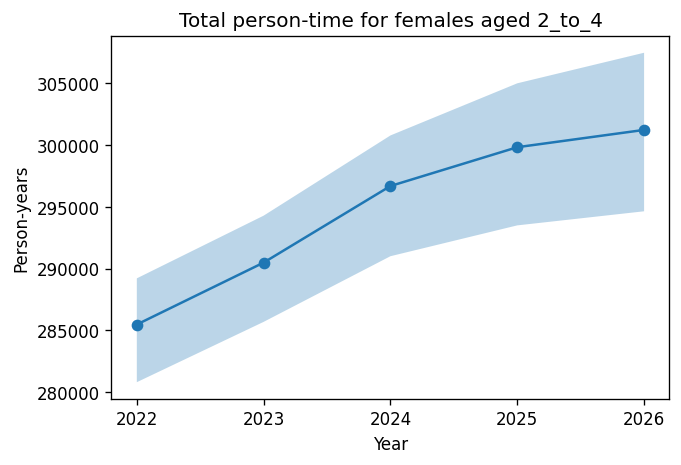

In [41]:
def plot_measure_by_year_for_sex_and_age(ax, df, measure, sex, age_group):
    df = df.query('sex==@sex and age==@age_group')
    ax.plot(df['year'], df['mean'], marker='o', label=f"{sex}, {age_group}")
    ax.fill_between(df['year'], df['lower'], df['upper'], alpha=0.3)
    ax.set_xlabel('Year')
    ax.set_ylabel('Person-years')
    ax.set_title(f"Total {measure} for {sex}s aged {age_group}")

fig, ax = plt.subplots(figsize=(6,4), dpi=120)
plot_measure_by_year_for_sex_and_age(ax, person_time_summary, 'person-time', 'female', '2_to_4')

In [42]:
ax.title.get_text()

'Total person-time for females aged 2_to_4'

## Draw all age groups together for each sex

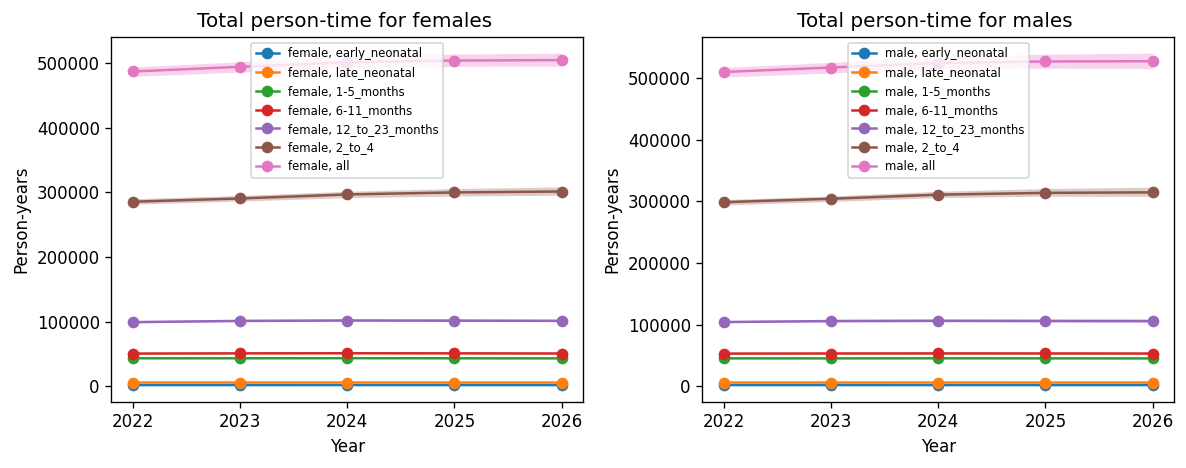

In [43]:
def plot_person_time_for_all_age_groups_by_sex(person_time_summary, sorted_ages, save_filepath=None):
    fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=120)
    for age in sorted_ages:
        plot_measure_by_year_for_sex_and_age(axs[0], person_time_summary, 'person-time', 'female', age)
        plot_measure_by_year_for_sex_and_age(axs[1], person_time_summary, 'person-time', 'male', age)
    for ax in axs:
        ax.legend(fontsize='x-small')
        # Titles were 'Total person-time for (fe)males aged all' from last age group, so reomve the age group
        ax.set_title(ax.title.get_text().replace('aged all', ''))
    fig.tight_layout()
    if save_filepath is not None:
        fig.savefig(save_filepath)
    return fig

person_time_by_sex_from_dd_observer_fig = plot_person_time_for_all_age_groups_by_sex(person_time_summary, sorted_ages)

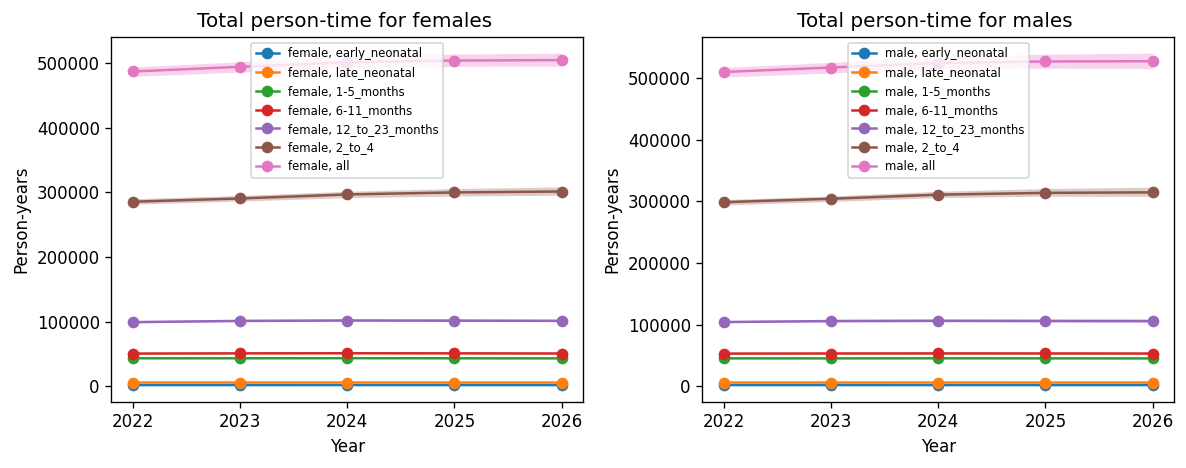

In [44]:
person_time_by_sex_from_dd_observer_fig

## Now draw separate plots for each age group and sex

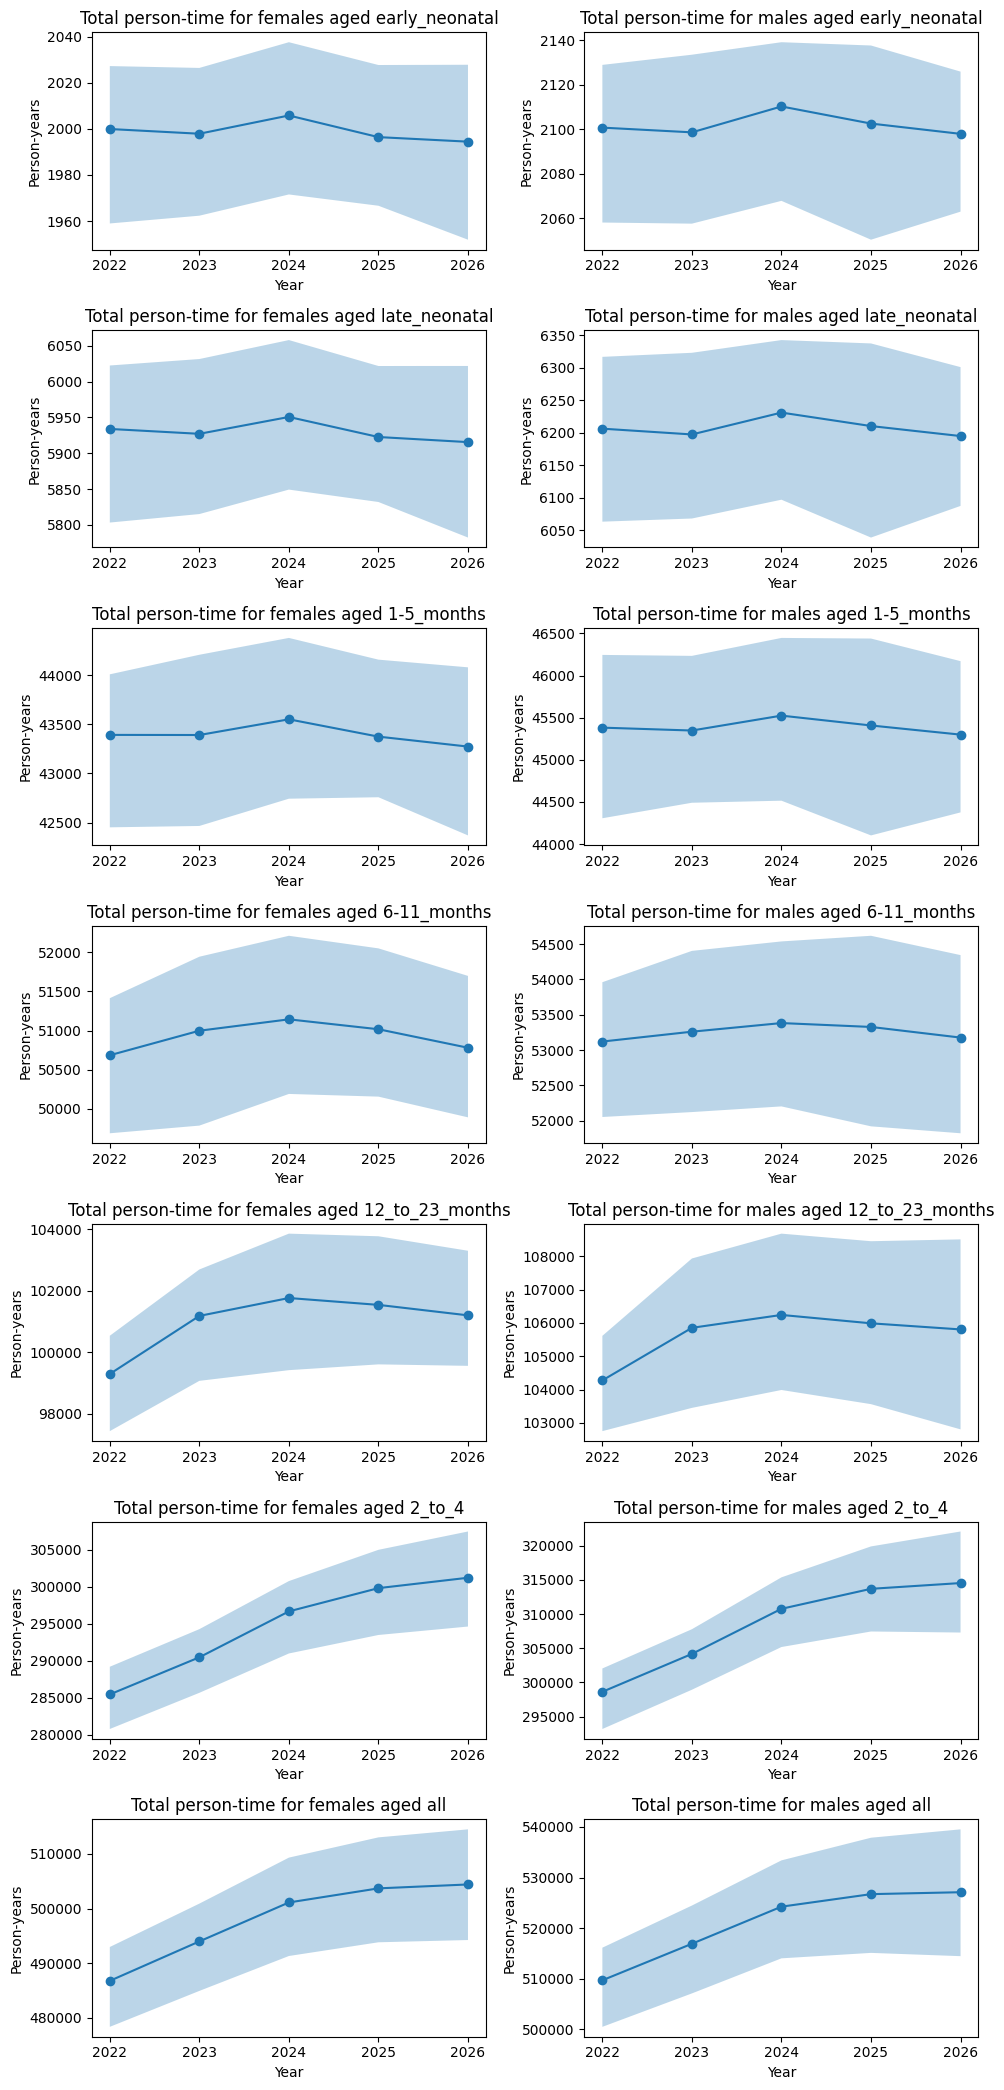

In [45]:
def plot_person_time_separately_by_age_and_sex(person_time_summary, sorted_ages, save_filepath=None):
    fig, axs = plt.subplots(len(sorted_ages), 2, figsize=(10,3*len(sorted_ages)), dpi=100)
    # axs.shape
    for axs_row, age in zip(axs, sorted_ages):
        plot_measure_by_year_for_sex_and_age(axs_row[0], person_time_summary, 'person-time', 'female', age)
        plot_measure_by_year_for_sex_and_age(axs_row[1], person_time_summary, 'person-time', 'male', age)
    fig.tight_layout()
    if save_filepath is not None:
        fig.savefig(save_filepath)
    return fig
    
person_time_by_age_sex_from_dd_observer_fig = plot_person_time_separately_by_age_and_sex(person_time_summary, sorted_ages)

# Save the plots

In [46]:
output_dir

'/ihme/homes/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.4_corrected_fertility'

In [47]:
!ls /ihme/homes/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation

v2.1_gbd_2020_wasting  v2.3_wasting_birth_prevalence  v2.4_corrected_fertility


In [48]:
share_output_dir

'/share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.4_corrected_fertility'

In [49]:
j_output_dir

'/home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v2.4_corrected_fertility'

## Save each of the 2 plots in all 3 output directories

In [50]:
for directory in [output_dir, share_output_dir, j_output_dir]:
    person_time_by_sex_from_dd_observer_fig.savefig(f"{directory}/person_time_by_sex_from_dd_observer.pdf")

In [51]:
for directory in [output_dir, share_output_dir, j_output_dir]:
    person_time_by_age_sex_from_dd_observer_fig.savefig(f"{directory}/person_time_by_age_sex_from_dd_observer.pdf")

In [52]:
!ls /ihme/homes/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.4_corrected_fertility/

person_time_by_age_sex_from_dd_observer.pdf
person_time_by_sex_from_dd_observer.pdf


In [53]:
!ls /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.4_corrected_fertility

person_time_by_age_sex_from_dd_observer.pdf
person_time_by_sex_from_dd_observer.pdf


In [54]:
!ls /home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v2.4_corrected_fertility

all_cause_mortality.pdf  measles_incidence.pdf
diarrhea_emr.pdf	 measles_mortality.pdf
diarrhea_incidence.pdf	 measles_prevalence.pdf
diarrhea_mortality.pdf	 pem_emr.pdf
diarrhea_prevalence.pdf  pem_mortality.pdf
diarrhea_remission.pdf	 pem_prevalence.pdf
lri_emr.pdf		 person_time_by_age_sex_from_dd_observer.pdf
lri_incidence.pdf	 person_time_by_age_sex_from_wasting_observer.pdf
lri_mortality.pdf	 person_time_by_sex_from_dd_observer.pdf
lri_prevalence.pdf	 person_time_by_sex_from_wasting_observer.pdf
lri_remission.pdf	 wasting_prevalence.pdf
measles_emr.pdf


# Try plotting person-time from the wasting observer instead of the DD observer

In [55]:
# Write a single function to combine my two functions from ciff_output_processing
def get_mean_lower_upper(df):
    return cop.get_mean_lower_upper(cop.describe(df, percentiles=[0.025,0.975]))
get_mean_lower_upper(d.population)

,measure,scenario,mean,lower,upper
0,total_population,baseline,2.068011e+06,2032020.650,2091865.100
1,total_population_dead,baseline,5.415508e+04,40511.425,62819.075
2,total_population_living,baseline,1.035594e+06,1012510.525,1058989.575
3,total_population_tracked,baseline,1.089749e+06,1070816.025,1103248.875
4,total_population_untracked,baseline,9.782616e+05,960997.550,991607.850


## Get total person time from the wasting observer by aggergating

In [56]:
d.wasting_state_person_time

,sex,year,wasting_state,measure,input_draw,scenario,value,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,405.629021,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,1209.319644,late_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,8750.485969,1-5_months
3,female,2022,mild_child_wasting,state_person_time,29,baseline,10229.859001,6-11_months
...,...,...,...,...,...,...,...,...
2876,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,29966.584531,1-5_months
2877,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,35341.488022,6-11_months
2878,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,70143.459274,12_to_23_months
2879,male,2026,susceptible_to_child_wasting,state_person_time,946,baseline,213284.266940,2_to_4


In [57]:
def get_all_ages_person_time(person_time):
    return marginalize(person_time, 'age').assign(age='all')[person_time.columns]

w_person_time = marginalize(d.wasting_state_person_time, 'wasting_state')
w_person_time = get_all_ages_person_time(w_person_time).append(w_person_time)

w_person_time_summary = get_mean_lower_upper(w_person_time)
w_person_time_summary

,age,measure,scenario,sex,year,mean,lower,upper
0,1-5_months,state_person_time,baseline,female,2022,43392.835843,42451.287714,44009.715777
1,1-5_months,state_person_time,baseline,female,2023,43391.629820,42465.237611,44208.982923
2,1-5_months,state_person_time,baseline,female,2024,43551.454255,42742.924538,44380.527139
3,1-5_months,state_person_time,baseline,female,2025,43375.110084,42757.755373,44159.286790
...,...,...,...,...,...,...,...,...
66,late_neonatal,state_person_time,baseline,male,2023,6197.427447,6068.135866,6323.009959
67,late_neonatal,state_person_time,baseline,male,2024,6231.045517,6097.066359,6342.577481
68,late_neonatal,state_person_time,baseline,male,2025,6210.325804,6038.846201,6337.396920
69,late_neonatal,state_person_time,baseline,male,2026,6194.960643,6087.504723,6300.969473


In [58]:
w_person_time_summary.age.unique()

array(['1-5_months', '12_to_23_months', '2_to_4', '6-11_months', 'all',
       'early_neonatal', 'late_neonatal'], dtype=object)

## Draw and save person-time plots from wasting observer

These plots look the same as the plots above, which is good.

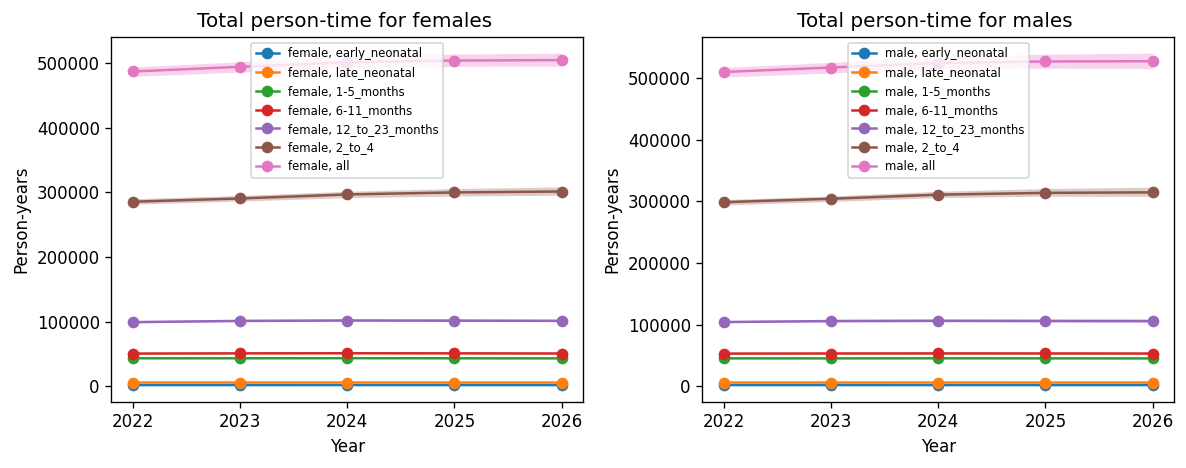

In [59]:
person_time_by_sex_from_wasting_observer_fig = plot_person_time_for_all_age_groups_by_sex(
    w_person_time_summary, sorted_ages, f"{j_output_dir}/person_time_by_sex_from_wasting_observer.pdf")

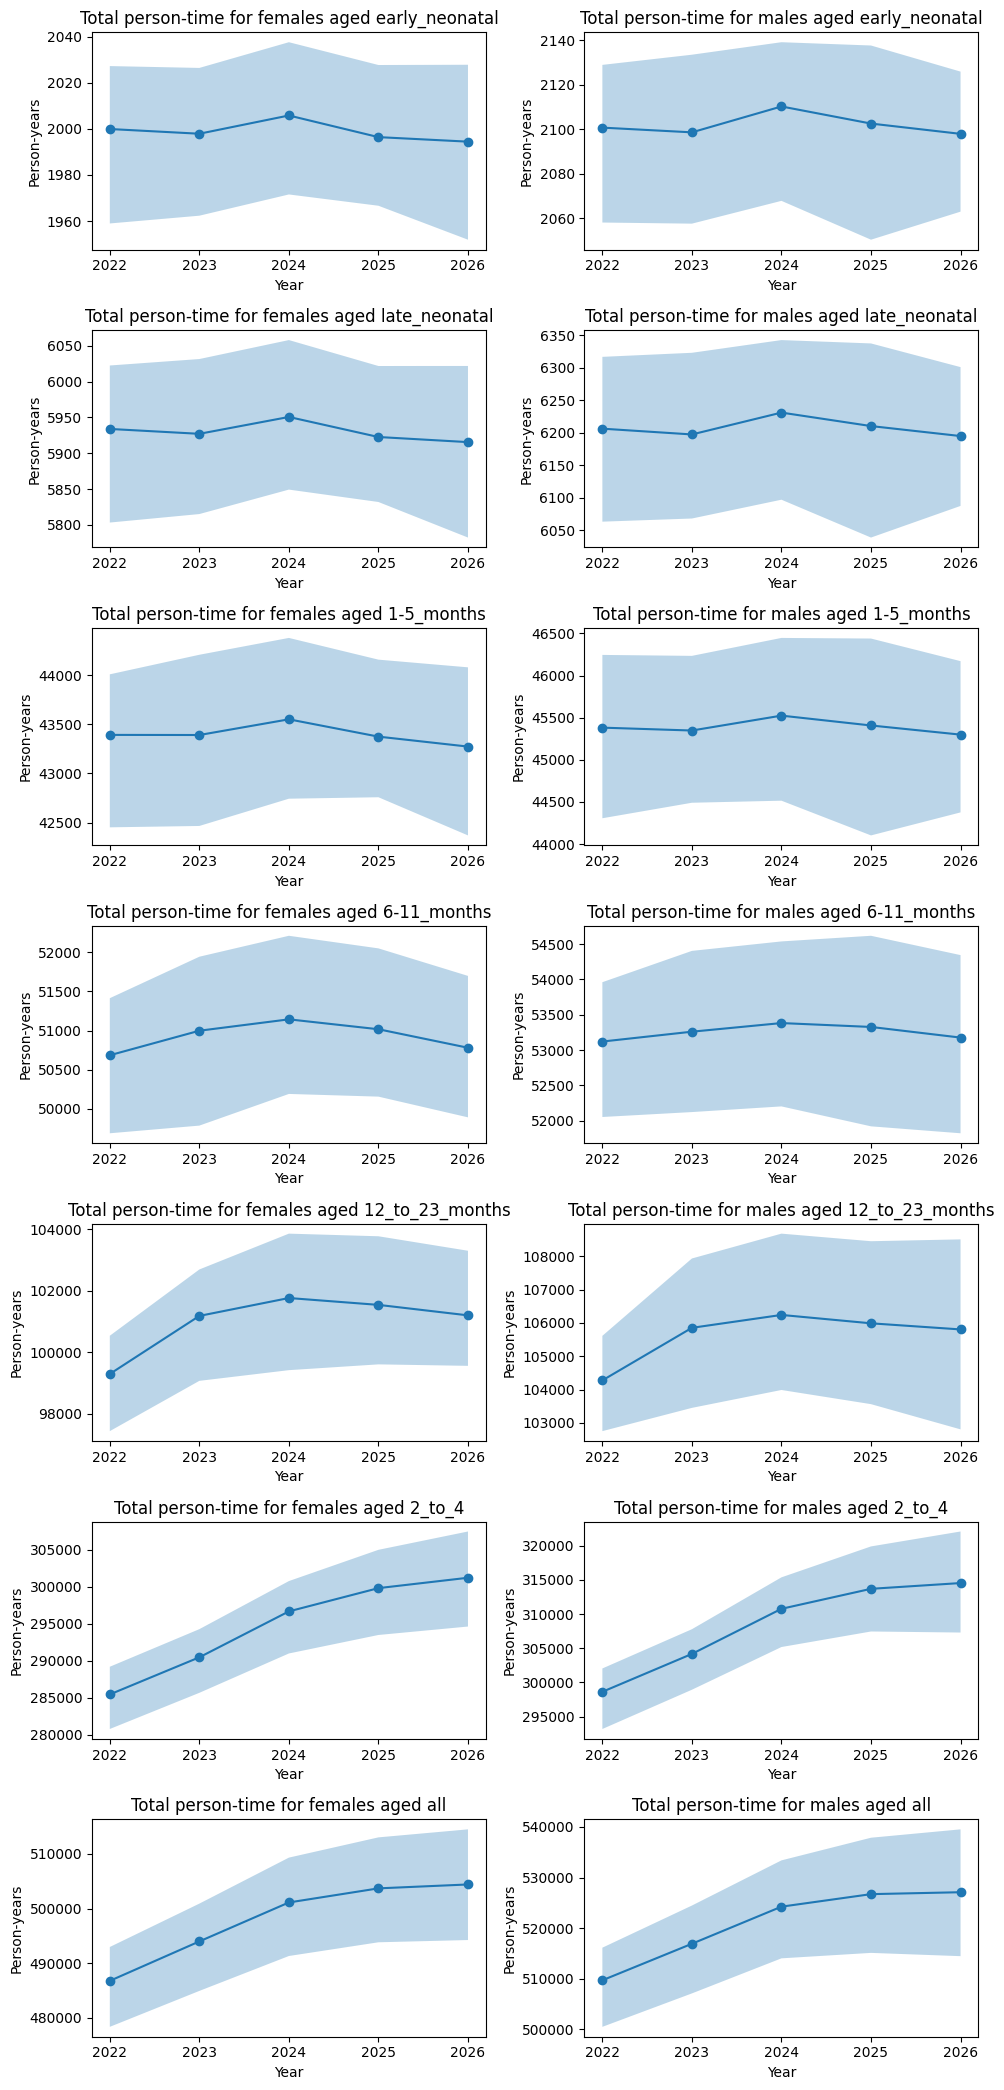

In [60]:
person_time_by_age_sex_from_wasting_observer_fig = plot_person_time_separately_by_age_and_sex(
    w_person_time_summary, sorted_ages, f"{j_output_dir}/person_time_by_age_sex_from_wasting_observer.pdf")

In [61]:
!ls /home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v2.4_corrected_fertility

all_cause_mortality.pdf  measles_incidence.pdf
diarrhea_emr.pdf	 measles_mortality.pdf
diarrhea_incidence.pdf	 measles_prevalence.pdf
diarrhea_mortality.pdf	 pem_emr.pdf
diarrhea_prevalence.pdf  pem_mortality.pdf
diarrhea_remission.pdf	 pem_prevalence.pdf
lri_emr.pdf		 person_time_by_age_sex_from_dd_observer.pdf
lri_incidence.pdf	 person_time_by_age_sex_from_wasting_observer.pdf
lri_mortality.pdf	 person_time_by_sex_from_dd_observer.pdf
lri_prevalence.pdf	 person_time_by_sex_from_wasting_observer.pdf
lri_remission.pdf	 wasting_prevalence.pdf
measles_emr.pdf
